#### Load the data: please retrieve the microbiome table and metadata tsv from https://github.com/shihuang047/age-prediction/tree/master/Input/skin_data . The table we will use is skin_1975.biom. The associated metadata is called 'skin_1975_map.txt' . You will need to make sure the index of the table and metadata match in order to keep track of the paired samples and metadata information. The target you are looking to predict is called 'qiita_host_age' , which represents the subjects age at the time of microbiome sample collection. The dataset we are using is from human skin microbiome samples and has been shown to be one of the best body sites for predicting host age. 

In [1]:
from biom import load_table
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [73]:
table =  load_table('age-prediction/Input/skin_data/skin_1975.biom').to_dataframe().T # use load_table to import the biom table as a dataframe. 
metadata = pd.read_csv('age-prediction/Input/skin_data/skin_1975_map.txt', delimiter='\t', dtype = {'qiita_host_age':float}) # use pd to import the tsv as a dataframe. also, use d_type to import the target 'qiita_host_age' as a float.
display(table)
display(metadata) 

/var/folders/hx/4d84tkkd6cd5brct_96mvvqw0000gn/T/ipykernel_86311/2335929641.py:2: DtypeWarning: Columns (124,384,841,844,968) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('age-prediction/Input/skin_data/skin_1975_map.txt', delimiter='\t', dtype = {'qiita_host_age':float}) # use pd to import the tsv as a dataframe. also, use d_type to import the target 'qiita_host_age' as a float.


,TACGGAAGGTTCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCTGGAGATTAAGTGTGTTGTGAAATGTAGACGCTCAACGTCTGACTTG,TACGAGGGGTGCAAGCGTTGCTCGGAATTATTGGGCGTAAAGGGTAGGTAGGTGGTCTCATTTGTCCGGGGTGAAAGCCTTGGGCTTAACTCAAGAAGTG,GACGGGGGATGCAAGTGTTATCCGGAATAATTGGGCGTAAAGCGTCTGTGGGTGGTTTACCAAGTCTGTTGTTAAAAATCAGGGCTTAACCCTGATCCGG,AACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGCCAGGTAAGCGTGTTGTGAAATGTACCGGCTCAACCGGTGAATTG,TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTCCGTAGGCGGCTCTGTAAGTCAGTGGTGAAATCTCATAGCTTAACTATGAAACTG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAGAACAAGTTGGAAGTGAAATCCATGGGCTCAACTCATGAACTG,TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTATGCAGGCGGACCGTTAGGTCGGAGGTGAAATCCCAGGGCTCAACCCTGGAACTG,TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCGATCTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTG,CACGTAGGCACCAAGCGTTGTACGGATTTATTGGGCGTAAAGAGCTTGTAGGCGGTTCGGTAAGTCGGGTGTGAAACCTCTGGGCTCAACTCAGAGACGC,TACGGAGGGTGCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGCAGGCGGTCTTATAAGTCAGTGTTGAAAGCCTACAGCTCAACTGTAGAACTG,...,TACGAACTGTGCGAACGTTATTCGGAATCACTGGGCTTACAGGGTGTGTAGGCGGCTTGTTAAGCAGGGTGTGAAATCCTCCGGCTCAACCGGGGAACGG,TACCAGCACCCCGAGTGGTCGGGACGATTATTGGGCCTAAAGCATCCGTAGCCGGTCACGCAAGTCTTCCGTTAAATCCACCCGCTCAACGGTTGGGCTG,TACGAGGGGGGCAAGCGTTGTTCGGAATTATTGGGCGTAAAGGGTGCGTAGGCGGTCTGATAAGTTTGGTGTGAAATCTCTGGGCTCAACCCAGAGTCTG,TAGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATTACAAGTCTGGGGTGAAATCTTGGTGCTTAACATTAAAATTGC,GACAGAGGCTGCAAGCGTTATCCGGAATGATTGGGCGTAAAGCGTCTGTAGGTGGCTTTTCAAGTCCGCCGTCAAATCCCAGGGCTCAACCCTGGACAAG,TACGGAAGGCCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGATTAAGTCAGCTGTGAAAGTTTGCGGCTCAACCGTAAAATTG,GACGAACCGAGCGAACGTTGTTCGGAATCACTGGGCTTAAAGGGCGCGTAGGCGGGCTATCAAGTCTGGGGTGAAATCCCGCGGCTCAACCGTGGAACTG,TACGGAGGGTGCAAGCGTTACTCAGAATCACTGGGCGTAAAGGACGCGTAGGCGGATTATCAAGTCTTTTGTGAAGTCTAATGGCTTAACCATTAAACTG,TACGTAGGCAGCAAGCGTTGTTCGGAGTTACTGGGCGTAAAGGGTGTGTAGGCGGTTGGATAAGAGTGGTGTGAAATCTCCCGGCTTAACTGGGAGGGTG,TACGAAGGGGGCTAGCGTTGCTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGCTCTGTTAGTCAGGCGTGAAATTCCCGGGCTTTACCTGGGGACTG
10317.000003638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1841.F06478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1841.F06479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1841.F06476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1841.F06474,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841.F05416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1841.F05822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10317.000009725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10317.000009722,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,#SampleID,achilles_tendinitis,acid_reflux,acne,acne_medication,acne_medication_otc,acute_kidney_failure,acute_liver_failure,add_0c,add_4c,...,qiita_host_ethnicity_black_or_african_american,qiita_host_ethnicity_hispanic_or_latino,qiita_host_ethnicity_asian,qiita_host_ethnicity_american_indian_or_alaska_native,qiita_host_ethnicity_native_hawaiian_or_other_pacific_islander,qiita_host_ethnicity_other,qiita_host_ethnicity_combined,age_groups,X_sample_id,X_calour_original_abundance
0,10317.000003638,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,50s,10317.000003638,36033
1,1841.F06478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,10s,1841.F06478,36089
2,1841.F06479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,20s,1841.F06479,33209
3,1841.F06476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,20s,1841.F06476,30406
4,1841.F06474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,20s,1841.F06474,30566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,1841.F05416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,20s,1841.F05416,41890
1971,1841.F05822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,30s,1841.F05822,32492
1972,10317.000009725,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,30s,10317.000009725,5184
1973,10317.000009722,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,30s,10317.000009722,13260


#### Some datasets have multiple samples for each individual and retaining these samples can sometimes introduce bias to our model training. Please remove rows/samples from the metadata so we only have one sample for each unqiue subject. The column in the metadata with this information is called 'host_subject_id' . You can just keep the first occurence of each subject in the metadata; however, don't forget to filter the microbiome table using the remaining metadata index in order to keep the samples consistent between your dataset and metadata!

In [76]:
metadata = metadata.drop_duplicates(subset = 'host_subject_id', keep = 'first')
# filter the metadata df to only keep the first occurence based on the host_subject_id. 
table_rows = np.array(metadata['#SampleID'])
table = table.loc[table_rows] #filter your table to have exactly the same index as the metadata. 
#np.shape(table.values)
table.index, np.shape(metadata)


(Index(['10317.000003638', '1841.F06478', '1841.F06479', '1841.F06476',
        '1841.F06474', '1841.F06472', '1841.F06471', '10317.000087026',
        '1841.F05357', '10317.000049806',
        ...
        '10317.000033792', '10317.000009071', '10317.000028943',
        '10317.000048360', '10317.000005654', '10317.000020770',
        '10317.000040133', '10317.000063380', '10317.000004846',
        '10317.000020763'],
       dtype='object', length=340),
 (340, 1101))

#### Normalize the data: Please consider normalizing the data in order to improve model performance. Some common transformations are np.log1p(), or various types of scaling. 

In [206]:
transformed_table = np.log1p(table)#scaler.fit_transform(table)#1 / (1 + np.exp(-table)) # transform the count data from the biom table called table in some way to normalize the data. scikit-learn also has a bunch of preprocesing steps we can use here.
np.shape(transformed_table.values), np.shape(metadata[['qiita_host_age']]) ,display(transformed_table), display(metadata)

,TACGGAAGGTTCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCTGGAGATTAAGTGTGTTGTGAAATGTAGACGCTCAACGTCTGACTTG,TACGAGGGGTGCAAGCGTTGCTCGGAATTATTGGGCGTAAAGGGTAGGTAGGTGGTCTCATTTGTCCGGGGTGAAAGCCTTGGGCTTAACTCAAGAAGTG,GACGGGGGATGCAAGTGTTATCCGGAATAATTGGGCGTAAAGCGTCTGTGGGTGGTTTACCAAGTCTGTTGTTAAAAATCAGGGCTTAACCCTGATCCGG,AACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGCCAGGTAAGCGTGTTGTGAAATGTACCGGCTCAACCGGTGAATTG,TACGGAGGGTGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTCCGTAGGCGGCTCTGTAAGTCAGTGGTGAAATCTCATAGCTTAACTATGAAACTG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAGAACAAGTTGGAAGTGAAATCCATGGGCTCAACTCATGAACTG,TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTATGCAGGCGGACCGTTAGGTCGGAGGTGAAATCCCAGGGCTCAACCCTGGAACTG,TACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCGATCTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTG,CACGTAGGCACCAAGCGTTGTACGGATTTATTGGGCGTAAAGAGCTTGTAGGCGGTTCGGTAAGTCGGGTGTGAAACCTCTGGGCTCAACTCAGAGACGC,TACGGAGGGTGCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGCAGGCGGTCTTATAAGTCAGTGTTGAAAGCCTACAGCTCAACTGTAGAACTG,...,TACGAACTGTGCGAACGTTATTCGGAATCACTGGGCTTACAGGGTGTGTAGGCGGCTTGTTAAGCAGGGTGTGAAATCCTCCGGCTCAACCGGGGAACGG,TACCAGCACCCCGAGTGGTCGGGACGATTATTGGGCCTAAAGCATCCGTAGCCGGTCACGCAAGTCTTCCGTTAAATCCACCCGCTCAACGGTTGGGCTG,TACGAGGGGGGCAAGCGTTGTTCGGAATTATTGGGCGTAAAGGGTGCGTAGGCGGTCTGATAAGTTTGGTGTGAAATCTCTGGGCTCAACCCAGAGTCTG,TAGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATTACAAGTCTGGGGTGAAATCTTGGTGCTTAACATTAAAATTGC,GACAGAGGCTGCAAGCGTTATCCGGAATGATTGGGCGTAAAGCGTCTGTAGGTGGCTTTTCAAGTCCGCCGTCAAATCCCAGGGCTCAACCCTGGACAAG,TACGGAAGGCCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGATTAAGTCAGCTGTGAAAGTTTGCGGCTCAACCGTAAAATTG,GACGAACCGAGCGAACGTTGTTCGGAATCACTGGGCTTAAAGGGCGCGTAGGCGGGCTATCAAGTCTGGGGTGAAATCCCGCGGCTCAACCGTGGAACTG,TACGGAGGGTGCAAGCGTTACTCAGAATCACTGGGCGTAAAGGACGCGTAGGCGGATTATCAAGTCTTTTGTGAAGTCTAATGGCTTAACCATTAAACTG,TACGTAGGCAGCAAGCGTTGTTCGGAGTTACTGGGCGTAAAGGGTGTGTAGGCGGTTGGATAAGAGTGGTGTGAAATCTCCCGGCTTAACTGGGAGGGTG,TACGAAGGGGGCTAGCGTTGCTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGCTCTGTTAGTCAGGCGTGAAATTCCCGGGCTTTACCTGGGGACTG
10317.000003638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1841.F06478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1841.F06479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1841.F06476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1841.F06474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10317.000020770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000040133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000063380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000004846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,#SampleID,achilles_tendinitis,acid_reflux,acne,acne_medication,acne_medication_otc,acute_kidney_failure,acute_liver_failure,add_0c,add_4c,...,qiita_host_ethnicity_black_or_african_american,qiita_host_ethnicity_hispanic_or_latino,qiita_host_ethnicity_asian,qiita_host_ethnicity_american_indian_or_alaska_native,qiita_host_ethnicity_native_hawaiian_or_other_pacific_islander,qiita_host_ethnicity_other,qiita_host_ethnicity_combined,age_groups,X_sample_id,X_calour_original_abundance
0,10317.000003638,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,50s,10317.000003638,36033
1,1841.F06478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,10s,1841.F06478,36089
2,1841.F06479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,20s,1841.F06479,33209
3,1841.F06476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,20s,1841.F06476,30406
4,1841.F06474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,20s,1841.F06474,30566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,10317.000020770,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,60s,10317.000020770,28905
1935,10317.000040133,NaN,I do not have this condition,NaN,False,False,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,60s,10317.000040133,746
1949,10317.000063380,NaN,I do not have this condition,NaN,False,False,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,30s,10317.000063380,15140
1952,10317.000004846,NaN,NaN,NaN,False,True,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,white,40s,10317.000004846,38571


((340, 116068), (340, 1), None, None)

#### Now split the dataset into the training and test dataset. Also, stratify the test/train split based on a metadata column. We tend to stratify so both the test and train dataset have samples for all the classes in the stratification column, as sometimes we get bias without stratification -- which isn't great for training a model. Try stratifying but the metadata columns 'body_site' . 

In [250]:
y = np.array(metadata['qiita_host_age'])# set your target variable here. we will be using the column qiita_host_age from the metadata. 
X_train, X_test, y_train, y_test = train_test_split(transformed_table.values, y, test_size=0.3, random_state=42, stratify=metadata[['body_site']])


np.shape(X_train), type(X_test), type(y_train), type(y_test)


((238, 116068), numpy.ndarray, numpy.ndarray, numpy.ndarray)

#### Here you will need a few common components for your deep learning model: Dataset, DataLoader, Model, device, criterion, optimizer.

1. Dataset: 
   A custom class that inherits from `torch.utils.data.Dataset`. It defines how to access and preprocess your data. The class typically implements `__init__()`, `__len__()`, and `__getitem__()` methods.

2. DataLoader:
   A PyTorch utility that wraps your Dataset and provides efficient batch loading, shuffling, and parallel data processing. It helps in iterating over the data during training and evaluation.

3. Model:
   A neural network architecture defined as a class inheriting from `torch.nn.Module`. It specifies the layers and the forward pass of your network.

4. device:
   Determines whether to use CPU or GPU (MPS for Apple Silicon) for computations. Using `torch.device()` allows your code to be device-agnostic.

5. criterion:
   The loss function used to measure the model's performance and guide the learning process. For regression tasks like age prediction, Mean Squared Error (MSELoss) is commonly used.

6. optimizer:
   An algorithm that adjusts the model's parameters to minimize the loss. Common choices include SGD (Stochastic Gradient Descent) and Adam. The optimizer updates the model's weights during training.

These components work together in the training loop: the DataLoader provides batches of data, which are passed through the Model. The criterion computes the loss, and the optimizer updates the model's parameters to minimize this loss.

#### Adjust batch_size as needed for your own device settings. This also depends on the size of your model; however, be careful because your computer will let you do whatever you want and you may end up crashing your laptop if you use up all of your RAM. 

In [220]:
# Create Dataset and DataLoader
class SimpleDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = SimpleDataset(X_train, y_train)
test_dataset = SimpleDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [209]:
device =  torch.device('mps') # Set the device for model training as 'mps' to use your M1 processor. 
print(torch.backends.mps.is_available()) 

True


In [258]:
# Create your model class. This will take in the input features for a row in the microbiome table and output a single value (the predicted host age value)
class AgeRegressionModel(nn.Module):
  def __init__(self, input_size):
    super(AgeRegressionModel, self).__init__()
    self.fc1 = nn.Linear(input_size, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128, 64)
    self.fc6 = nn.Linear(64, 32)
    self.fc7 = nn.Linear(32, 16)
    self.fc8 = nn.Linear(16, 8)
    self.fc9 = nn.Linear(8, 1)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = torch.relu(self.fc8(x))
    x = self.fc9(x)
    return x
    

In [211]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            all_predictions.append(outputs.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all batches
    predictions = torch.cat(all_predictions, dim=0).numpy()
    actual = torch.cat(all_labels, dim=0).numpy()
    return predictions, actual

Epoch [1/150], Train Loss: 39.4618, Test Loss: 38.0444
Epoch [2/150], Train Loss: 39.0767, Test Loss: 37.9739
Epoch [3/150], Train Loss: 38.5611, Test Loss: 37.8929
Epoch [4/150], Train Loss: 39.2745, Test Loss: 37.8081
Epoch [5/150], Train Loss: 38.2552, Test Loss: 37.7217
Epoch [6/150], Train Loss: 38.0857, Test Loss: 37.6339
Epoch [7/150], Train Loss: 37.3382, Test Loss: 37.5447
Epoch [8/150], Train Loss: 36.9470, Test Loss: 37.4555
Epoch [9/150], Train Loss: 36.9665, Test Loss: 37.3638
Epoch [10/150], Train Loss: 37.3130, Test Loss: 37.2693
Epoch [11/150], Train Loss: 38.0960, Test Loss: 37.1717
Epoch [12/150], Train Loss: 38.2988, Test Loss: 37.0703
Epoch [13/150], Train Loss: 37.6461, Test Loss: 36.9643
Epoch [14/150], Train Loss: 37.7025, Test Loss: 36.8528
Epoch [15/150], Train Loss: 37.1486, Test Loss: 36.7348
Epoch [16/150], Train Loss: 37.7140, Test Loss: 36.6095
Epoch [17/150], Train Loss: 38.4359, Test Loss: 36.4747
Epoch [18/150], Train Loss: 37.4722, Test Loss: 36.3284
E

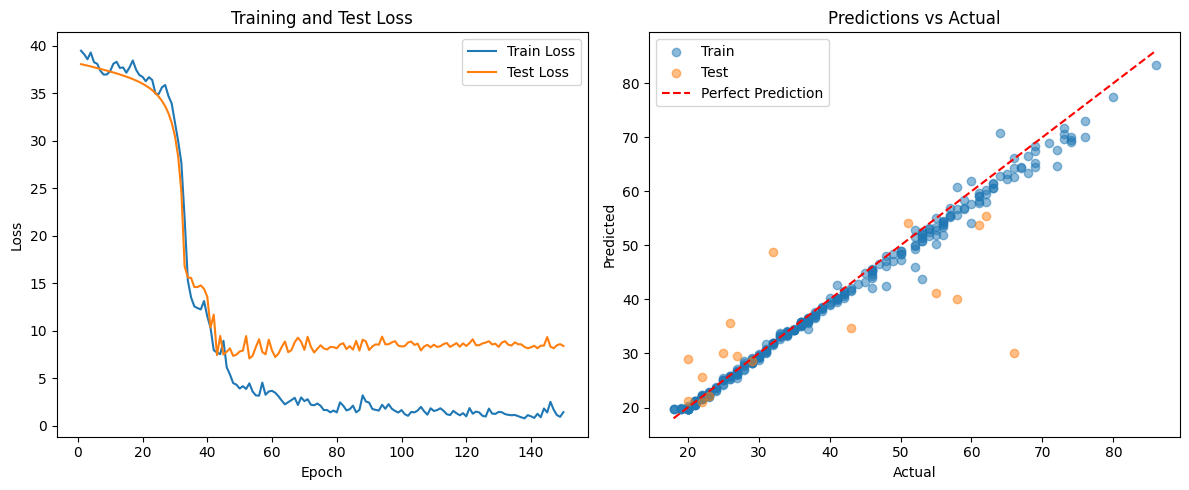

Final Train Loss: 1.4373
Final Test Loss: 8.4008


In [260]:
input_size = 116068 # Get input size from the microbiome table--> this should be equal to the number of features/columns in the table for each sample/row
model = AgeRegressionModel(input_size).to(device)
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.0007, momentum=0.9, weight_decay=0.001)

num_epochs = 150
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Evaluate on test set
    test_predictions, test_actual = evaluate(model, test_loader, device)
    test_loss = criterion(torch.tensor(test_predictions), torch.tensor(test_actual).unsqueeze(1)).item()
    test_losses.append(test_loss)
    
    #if (epoch + 1) % 10 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# 5. Final evaluation
train_predictions, train_actual = evaluate(model, train_loader, device)
test_predictions, test_actual = evaluate(model, test_loader, device)

# 6. Plotting
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot predictions vs actual
plt.subplot(1, 2, 2)
plt.scatter(train_actual, train_predictions, label='Train', alpha=0.5)
plt.scatter(test_actual, test_predictions, label='Test', alpha=0.5)
plt.plot([min(train_actual), max(train_actual)], [min(train_actual), max(train_actual)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

# Print final losses
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

# Reflection Questions

After completing this assignment, take a moment to reflect on the following questions. Each answer should be 1-2 sentences.

1. Why is data normalization important in machine learning, and how might it affect the performance of your age prediction model?

Data normalization is important in machine learning because it prevents the model from being too heavily impacted by extremely large values in the data set. 

2. How does stratification in train-test splitting help prevent bias, and why is it particularly important when working with data from multiple studies?

Stratification in train-test splitting is helpful in preventing bias because of how it splits the training and test data proportional based on the given criteria to have the same proportion of that criteria present in both the training and test datasets, without it the split would be random and the model would could be trained on data that does a poor job of reflecting the larger sample as a whole. It is important when working with data from different studies because those studies could have different characteristics and if characteristics from one study are not present in the training data it could implement a bias in the model.

3. What are the potential drawbacks of using a simple fully connected neural network for this task, and how might more advanced architectures like residual blocks or attention mechanisms address these issues?

One of the major drawback for a FCNN trying to do the task of predicting a persons age given certain information on their microbiome, is the number of features that are in the microbiome data table. This makes it difficult for the a simple fully connected nueural network to work out different paterns and generalizations in the data which can result in problems such as overfitting. 

4. How does the choice of loss function (e.g., MSE vs. MAE) impact the training process and final predictions in a regression task like age prediction?

From what I saw the MSE loss function would be extremely good for the training process of the data, getting the loss for training down to about 
0.0001  however it would be bad for the final prediction as the test loss would usually be somewhere about 150, the MSE loss function also only performed like this when I lowered the learning rate to .0001. However, for the MAE loss function although the training loss for the model would be worse (usually somewhere around 1 or 2) the test loss for the model would be much better (usually around 9 or 10), in both cases the model seemed to predict similar results for the final prediction based on the generated graph. 

5. Considering the biological nature of the microbiome data, what additional preprocessing steps or feature selection methods might be beneficial for improving the model's performance and interpretability?

One way to improve the model's performance is to introduce feature selection methods, that help the model undestand which types microbial information is most predictive of the a person's age. Once the features that contribute the greatest to the knowledge of a person's age are found, we can begin to eliminate the data form the microbiome data table that is irrelevant which would help the model be less confused, because of the reduced complexity of the task due to the less features. 